**SERVICIO EDUCACIONAL HOGAR Y SALUD DEL NORTE**

**INDICADOR: Cantidad total de productos inventariados anualmente por categoría**


Christian Ovalle

In [1]:
!pip install --upgrade pip
!pip install pandas==2.2.2
!pip install numpy==1.25.2 # Downgrade numpy
!pip install scikit-learn==1.3.1 xgboost==2.1.1


  Using cached scikit_learn-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached xgboost-2.1.1-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
Using cached scikit_learn-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.9 MB)
Using cached xgboost-2.1.1-py3-none-manylinux_2_28_x86_64.whl (153.9 MB)
  Attempting uninstall: scikit-learn
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/2 [xgboost]    WARNING: Ignoring invalid distribution ~gboost (/usr/local/lib/python3.11/dist-packages)
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [scikit-learn]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have 

**1. PREPARACIÓN DE LA DATA**

  En esta sección se preparan los datos necesarios para aplicar el modelo. Se realiza la instalación de bibliotecas, la lectura del archivo Excel, la transformación de los datos, la aplicación de técnicas pertinentes de preprocesamiento de datos y la separación de los datos en conjuntos de entrenamiento y prueba.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
import warnings
from scipy.stats import zscore
from sklearn.pipeline import Pipeline
warnings.filterwarnings("ignore")

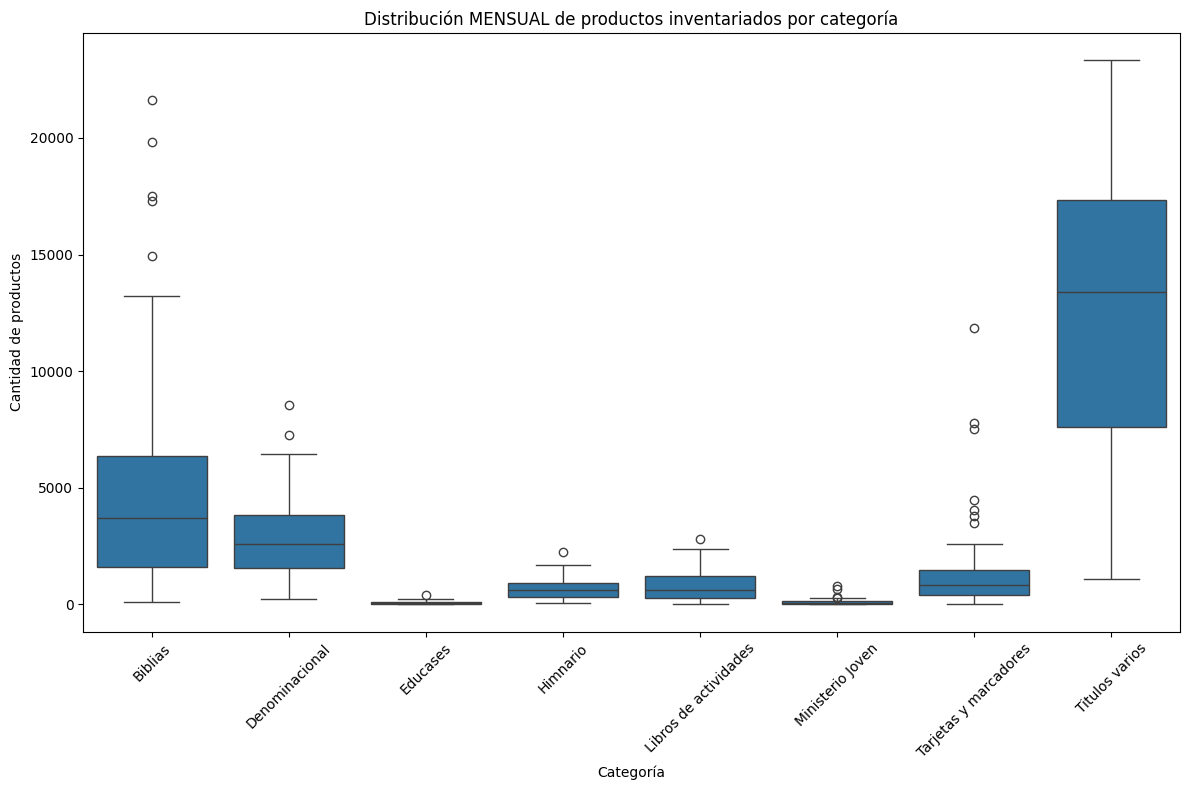

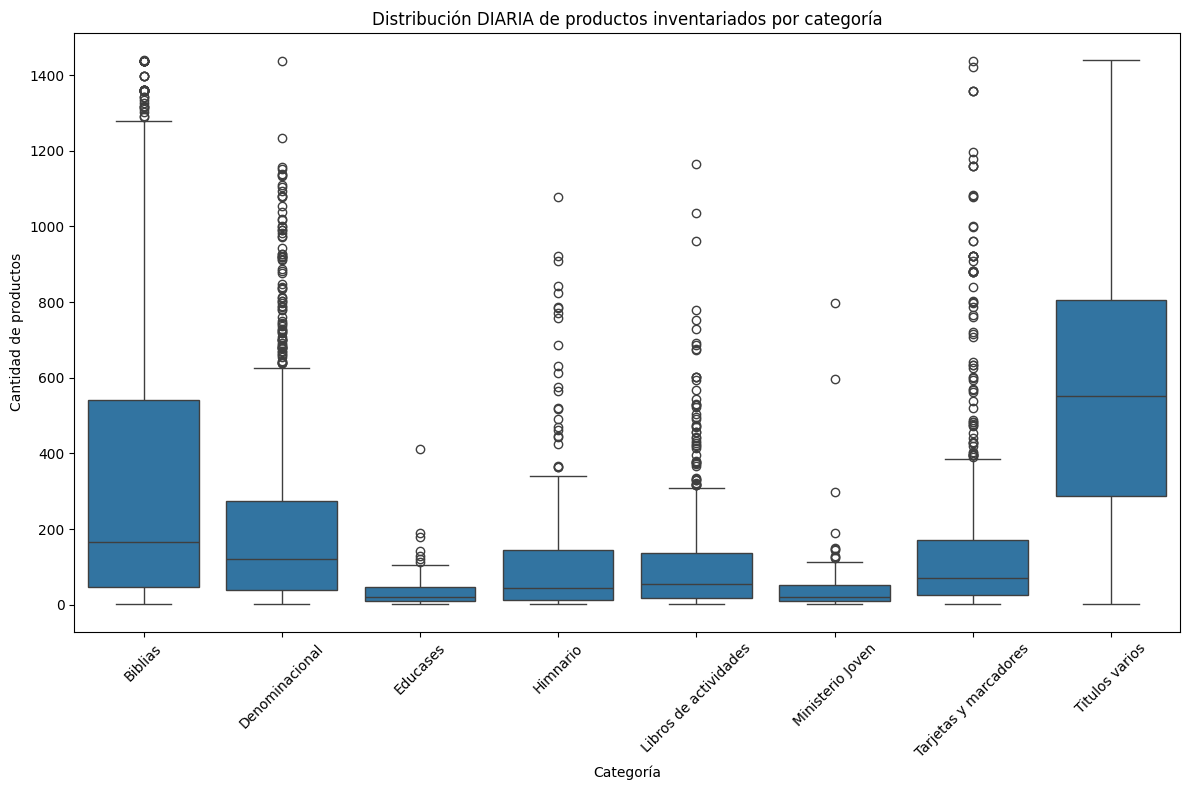

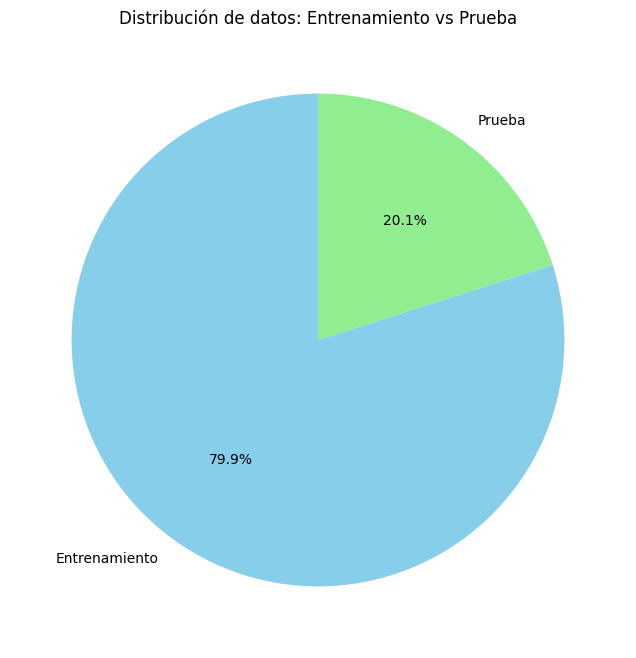

In [5]:
# Cargar el dataset
file_path = "/content/Datasets_Base_familias.xlsx"
dataset = pd.read_excel(file_path)

# --- ANÁLISIS MENSUAL ---
# Preparación de los datos (MANTENIENDO VARIABLES ORIGINALES)
data = pd.DataFrame()
data['categoria'] = dataset['Categoria']
data['cantidad'] = dataset['Cantidad']
data['fecha'] = dataset['fecha'].dt.to_period('M')

# Agrupar las ventas por categoría y mes (SUMA MENSUAL)
df_sum_categoria = data.groupby(['categoria', 'fecha'])['cantidad'].sum().reset_index()
df_sum_categoria['cantidad'] = df_sum_categoria['cantidad'].round()
df_sum_categoria['fecha'] = pd.to_datetime(df_sum_categoria['fecha'].astype(str), format='%Y-%m')

# --- ANÁLISIS DIARIO  ---
# Preparación de datos diarios
data_diario = pd.DataFrame()
data_diario['categoria'] = dataset['Categoria']  # Misma categoría
data_diario['cantidad'] = dataset['Cantidad']  # Misma cantidad
data_diario['fecha'] = dataset['fecha'].dt.normalize()  # Fecha diaria sin hora

# Agrupar por día (SUMA DIARIA)
df_sum_diario = data_diario.groupby(['categoria', 'fecha'])['cantidad'].sum().reset_index()
df_sum_diario['cantidad'] = df_sum_diario['cantidad'].round()

# --- MANEJO DE OUTLIERS (PARA AMBAS VERSIONES) ---
# Para mensual
z_scores = zscore(df_sum_categoria['cantidad'])
df_sum_categoria = df_sum_categoria[(np.abs(z_scores) < 3)]

# Para diario
z_scores_diario = zscore(df_sum_diario['cantidad'])
df_sum_diario = df_sum_diario[(np.abs(z_scores_diario) < 3)]

# --- GRÁFICO MENSUAL  ---
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_sum_categoria, x='categoria', y='cantidad')
plt.title('Distribución MENSUAL de productos inventariados por categoría')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de productos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- GRÁFICO DIARIO  ---
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_sum_diario, x='categoria', y='cantidad')
plt.title('Distribución DIARIA de productos inventariados por categoría')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de productos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Convertir las categorías a variables dummy (DATOS MENSUALES)
df_encoded = pd.get_dummies(df_sum_categoria, columns=['categoria'])
df_encoded['Year'] = df_encoded['fecha'].dt.year
df_encoded['Month'] = df_encoded['fecha'].dt.month

# Lista única de categorías
categorias = df_sum_categoria['categoria'].unique()

# Filtrar los datos para el entrenamiento y validación
df_train = df_encoded[df_encoded['Year'] < 2024]
df_test = df_encoded[df_encoded['Year'] >= 2020]

# Definir características (X) y objetivo (y)
X = df_train.drop(columns=['cantidad', 'fecha'])
y = df_train['cantidad']

# Definir X_test con las mismas columnas que X
X_test = df_test[X.columns]
y_test = df_test['cantidad']

# Division aleatoria de los datos para el entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalamiento de las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Visualización de la división de datos
division_labels = ['Entrenamiento', 'Prueba']
division_sizes = [len(X_train), len(X_test)]

plt.figure(figsize=(8, 8))
plt.pie(division_sizes, labels=division_labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen'])
plt.title('Distribución de datos: Entrenamiento vs Prueba')
plt.show()

**2. SELECCIÓN DE LOS MODELOS**

Se definen los modelos base que participarán en el conjunto (Stacking), como KNN, XGBoost y Random Forest, junto con el meta-modelo, que combina las predicciones de los modelos base. Esta selección se realiza en función de sus capacidades para manejar datos tabulares y ofrecer un buen equilibrio entre rendimiento y flexibilidad.

In [ ]:
def build_stacking_model():
    # Modelos base
    estimators = [
        ('knn', KNeighborsRegressor()),
        ('xgb', XGBRegressor(objective='reg:squarederror')),
        ('rf', RandomForestRegressor())
    ]
    stacking_model = StackingRegressor(
        estimators=estimators,
        final_estimator=LinearRegression(),
        cv=10
    )
    return stacking_model

**3. ENTRENAMIENTO DEL MODELO**

Se entrena cada modelo base utilizando los datos de entrenamiento procesados. Cada modelo aprende patrones en los datos de forma independiente, generando predicciones que más tarde se combinarán para formar el modelo de Stacking.

In [ ]:
# 3. ENTRENAMIENTO DE LOS MODELOS BASE
stacking_model = build_stacking_model()
stacking_model.fit(X_train_scaled, y_train)

StackingRegressor(cv=10,
                  estimators=[('knn', KNeighborsRegressor()),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            inte...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                              ('rf', RandomForestRegressor())],
                  final_estimator=LinearRegression())


**4. OPTIMIZACIÓN DE LOS HIPERPARÁMETROS**

En esta etapa, se optimizan los parámetros de los modelos base utilizando RandomizedSearchCV, lo que permite encontrar combinaciones de hiperparámetros que maximizan el desempeño del modelo. Al final, se seleccionan e imprimen los mejores hiperparámetros para cada modelo base, mejorando la precisión del conjunto.

Fitting 30 folds for each of 5 candidates, totalling 150 fits
Mejores hiperparámetros encontrados:
{'xgb__n_estimators': 150, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.1, 'rf__n_estimators': 100, 'rf__min_samples_split': 10, 'rf__max_depth': 10, 'knn__p': 4, 'knn__n_neighbors': 7}


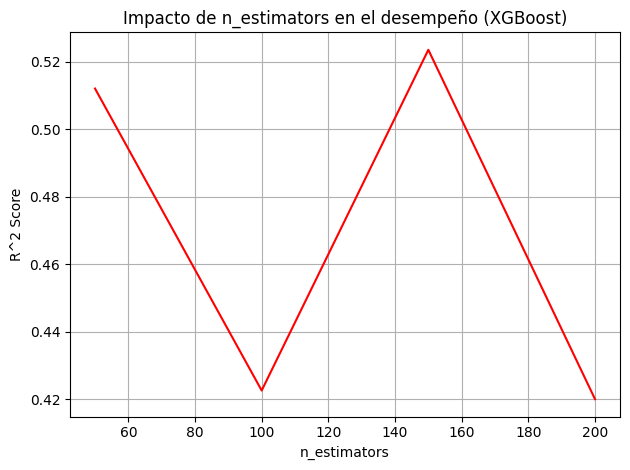

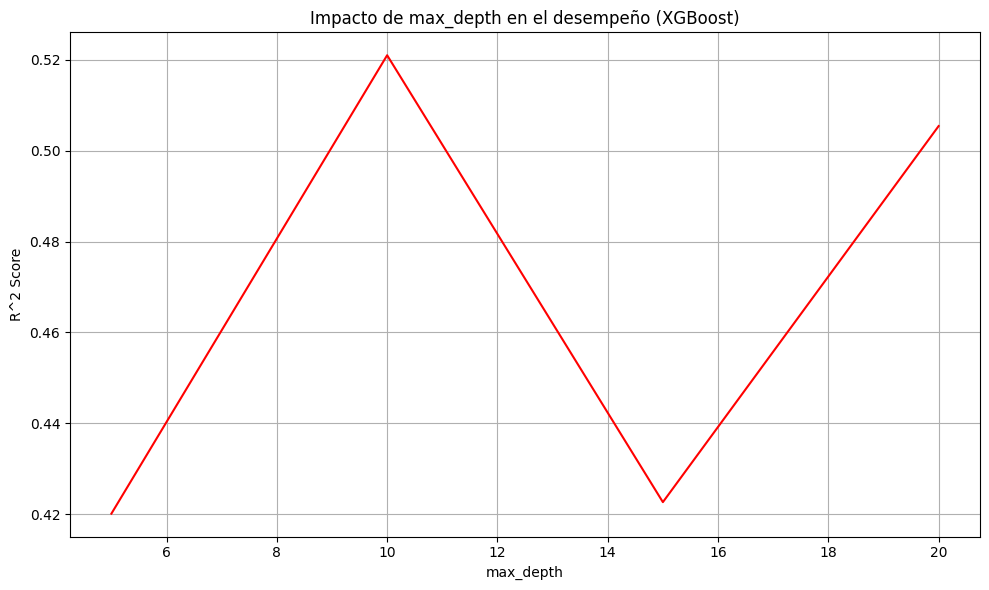

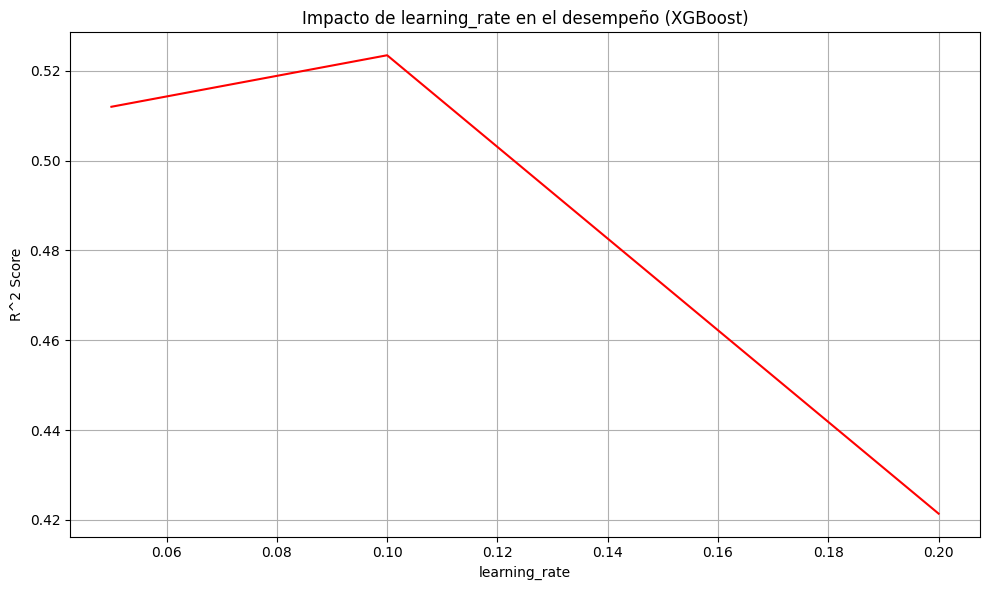

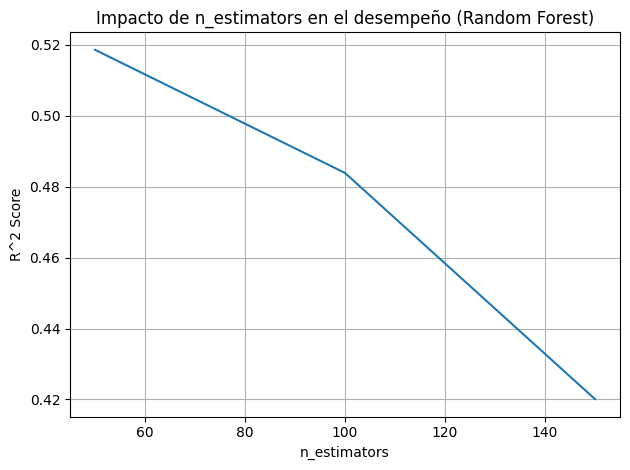

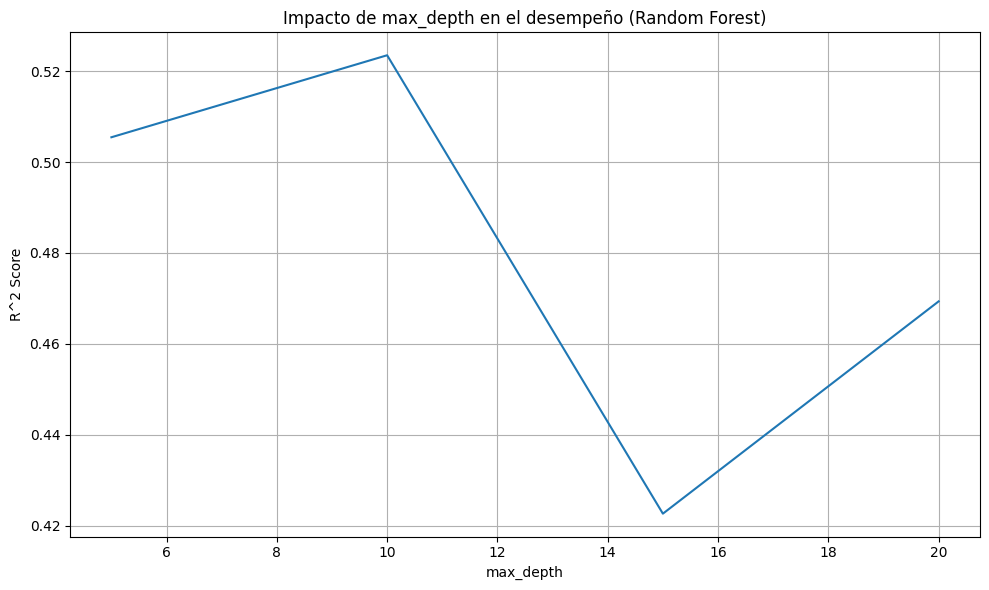

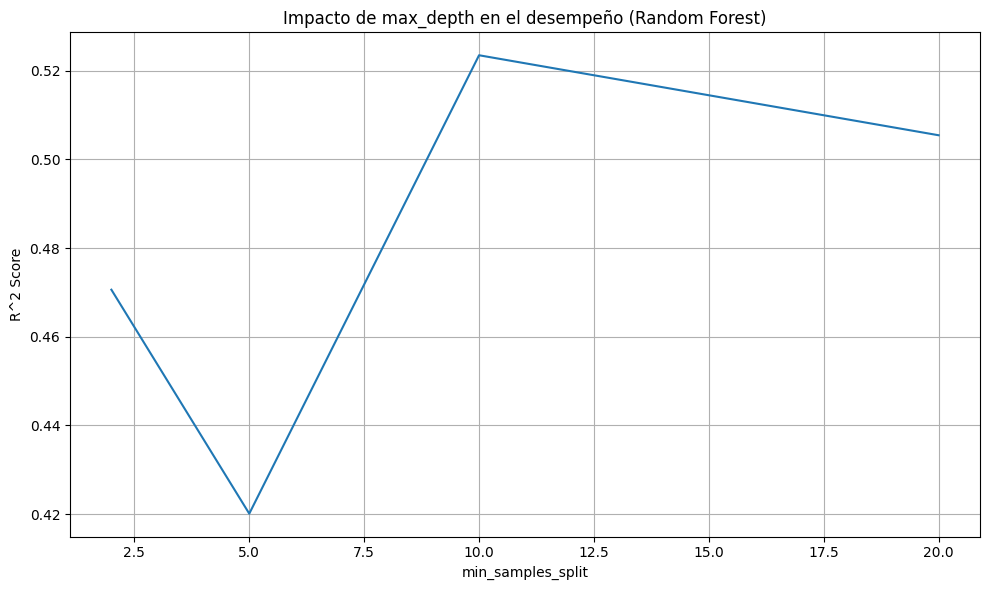

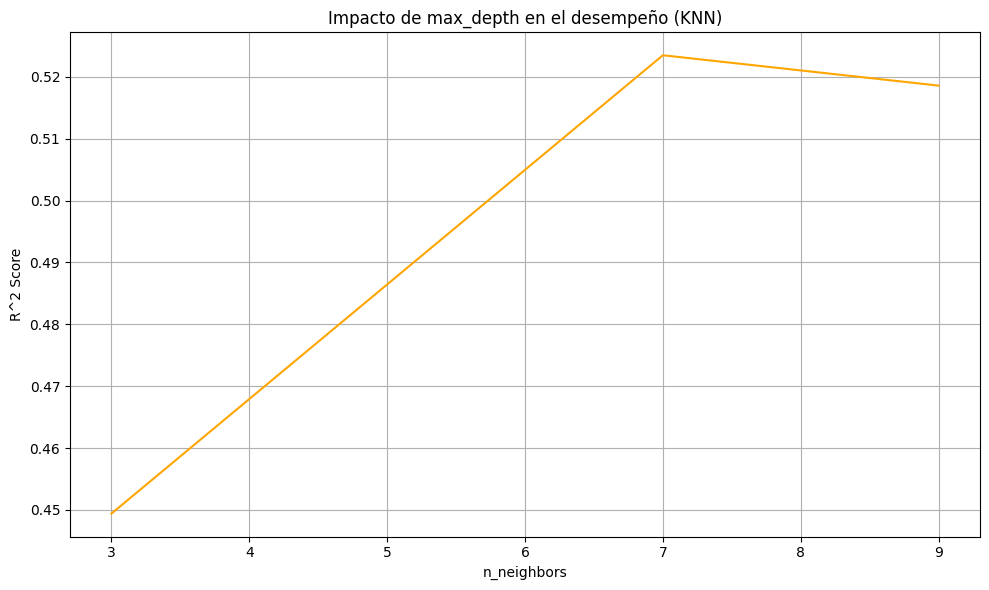

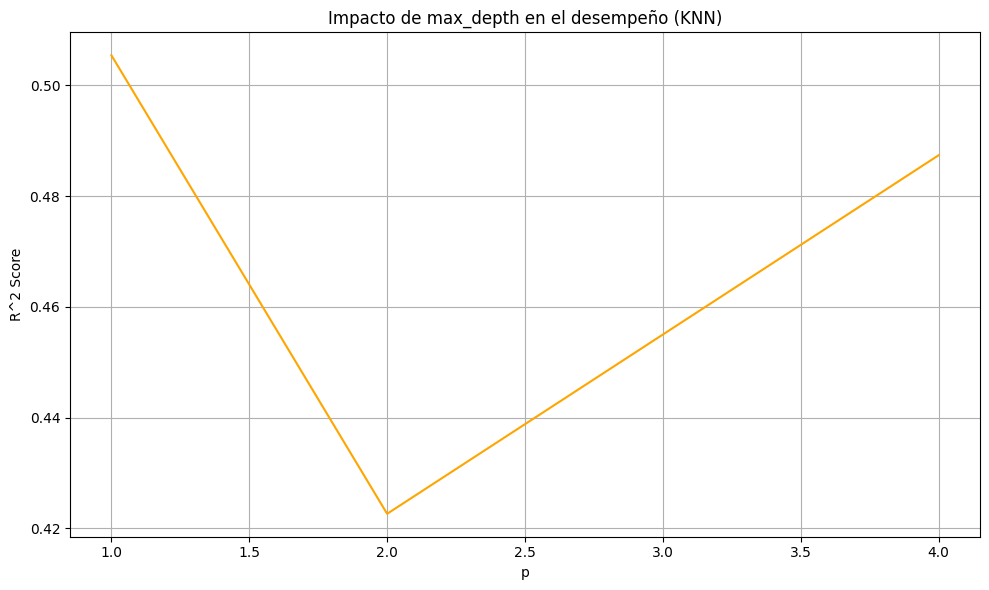

In [ ]:
# 4. OPTIMIZACIÓN DE LOS HIPERPARÁMETROS
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__p': [1, 2, 3, 4, 5],
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgb__max_depth': [5, 10, 15, 20],
    'xgb__n_estimators': [50, 100, 150, 200],
    "rf__n_estimators": [50, 100, 150, 200],
    "rf__max_depth": [5, 10, 15, 20],
    "rf__min_samples_split": [2, 5, 10, 20]
}
random_search = RandomizedSearchCV(
    estimator=build_stacking_model(),
    param_distributions=param_grid,
    scoring='r2',
    n_iter=5,
    cv=30,
    verbose=2,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train_scaled, y_train)
best_model = random_search.best_estimator_

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

# Resultados del ajuste de hiperparámetros
results = pd.DataFrame(random_search.cv_results_)

# Gráficas de la iteración de los hiperparámetros con respecto a R^2

#Para XGboost
xgb_results = results[["param_xgb__n_estimators", "param_xgb__learning_rate", "param_xgb__max_depth", "mean_test_score"]]

sns.lineplot(x="param_xgb__n_estimators", y="mean_test_score", data=xgb_results, errorbar=None, color='red')
plt.title("Impacto de n_estimators en el desempeño (XGBoost)")
plt.xlabel("n_estimators")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x="param_xgb__max_depth", y="mean_test_score", data=xgb_results, errorbar= None, color='red')
plt.title("Impacto de max_depth en el desempeño (XGBoost)")
plt.xlabel("max_depth")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x="param_xgb__learning_rate", y="mean_test_score", data=xgb_results, errorbar= None,color='red')
plt.title("Impacto de learning_rate en el desempeño (XGBoost)")
plt.xlabel("learning_rate")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()


# Para Random Forest
rf_results = results[["param_rf__n_estimators", "param_rf__max_depth", "param_rf__min_samples_split", "mean_test_score"]]

# Gráfico para n_estimators
sns.lineplot(x="param_rf__n_estimators", y="mean_test_score", data=rf_results, errorbar= None)
plt.title("Impacto de n_estimators en el desempeño (Random Forest)")
plt.xlabel("n_estimators")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

# Gráfico para max_depth
plt.figure(figsize=(10, 6))
sns.lineplot(x="param_rf__max_depth", y="mean_test_score", data=rf_results, errorbar= None)
plt.title("Impacto de max_depth en el desempeño (Random Forest)")
plt.xlabel("max_depth")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

# Gráfico para min_samples_split
plt.figure(figsize=(10, 6))
sns.lineplot(x="param_rf__min_samples_split", y="mean_test_score", data=rf_results, errorbar= None)
plt.title("Impacto de max_depth en el desempeño (Random Forest)")
plt.xlabel("min_samples_split")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()


# Para KNN
KNN_results = results[["param_knn__n_neighbors", "param_knn__p", "mean_test_score"]]

plt.figure(figsize=(10, 6))
sns.lineplot(x="param_knn__n_neighbors", y="mean_test_score", data=KNN_results, errorbar= None, color='orange')
plt.title("Impacto de max_depth en el desempeño (KNN)")
plt.xlabel("n_neighbors")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x="param_knn__p", y="mean_test_score", data=KNN_results, errorbar= None, color='orange')
plt.title("Impacto de max_depth en el desempeño (KNN)")
plt.xlabel("p")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

**5. FORMACIÓN DEL STACK**

  En esta etapa, se combinan las predicciones de los modelos base (KNN, XGboost y Random Forest) para que sirvan de entrata al meta-modelo, en este caso, una regresión lineal. El meta-modelo utiliza las predicciones de los modelos base como características para aprender a mejorar la precisión del conjunto. Esto resulta en un modelo más robusto que aprovecha las fortalezas individuales de los modelos base.

In [ ]:
# 5. FORMACIÓN DEL STACK
best_model.fit(X_train_scaled, y_train)

StackingRegressor(cv=10,
                  estimators=[('knn', KNeighborsRegressor(n_neighbors=7, p=4)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importan...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=150, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                              ('rf',
                               RandomForestRegressor(max_depth=10,
                                                     min_samples_split=10))],
                  final_estimator=LinearRegression())

**6. PREDICCIÓN DEL STACK**

  Una vez entrenado el modelo de Stacking, se utiliza para realizar predicciones en los datos de prueba. En esta etapa, se obtienen las predicciones finales del conjunto, integrando las salidas de los modelos base con el modelo meta. Estas predicciones reflejan el desempeño conjunto de todo el modelo de Stacking.

In [ ]:
y_pred = best_model.predict(X_test_scaled)


**7. EVALUACIÓN DEL MODELO**

  La etapa de evaluación tiene como objetivo medir el rendimiento del modelo en los datos de prueba. Se utilizan métricas como el error cuadrático medio (MSE), el coeficiente de determinación (R²), el error absoluto medio (MAE) y la raíz del error cuadrático medio (RMSE) para evaluar qué tan cercanas son las predicciones a los valores reales. También se emplean visualizaciones (gráficos de dispersión y líneas) para comparar visualmente los valores reales y predichos.

  Estas etapas aseguran que el modelo final sea confiable y su desempeño sea transparente tanto estadísticamente como gráficamente.

Métricas para KNN:
  Mean Squared Error (MSE): 0.0194
  R^2 Score: 0.7019
  Mean Absolute Error (MAE): 0.0848
  Root Mean Squared Error (RMSE): 0.1392

Métricas para XGBoost:
  Mean Squared Error (MSE): 0.0315
  R^2 Score: 0.5152
  Mean Absolute Error (MAE): 0.1073
  Root Mean Squared Error (RMSE): 0.1775

Métricas para Random Forest:
  Mean Squared Error (MSE): 0.0234
  R^2 Score: 0.6401
  Mean Absolute Error (MAE): 0.0914
  Root Mean Squared Error (RMSE): 0.1530

Métricas del Stacking (Salida del Meta-modelo):
  Mean Squared Error (MSE): 0.0189
  R^2 Score: 0.7087
  Root Mean Squared Error (RMSE): 0.1376
  Mean Absolute Error (MAE): 0.0846



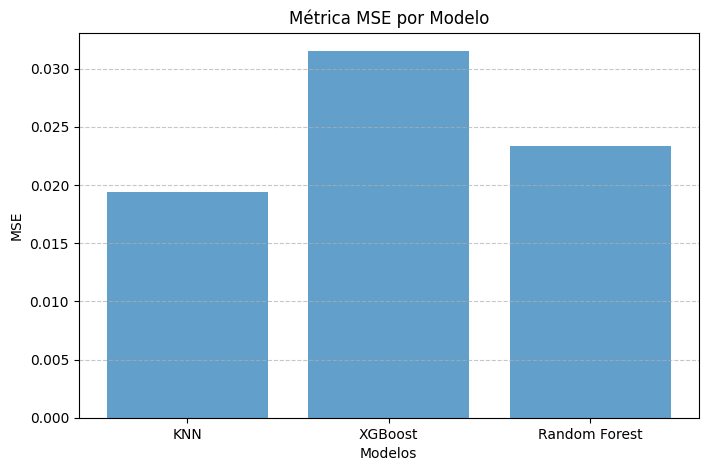

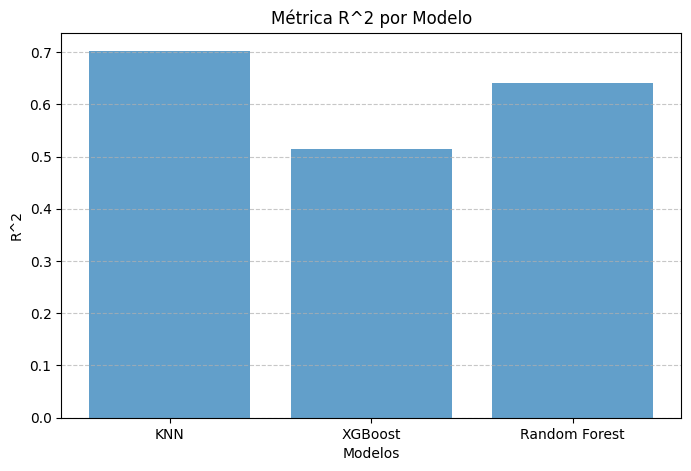

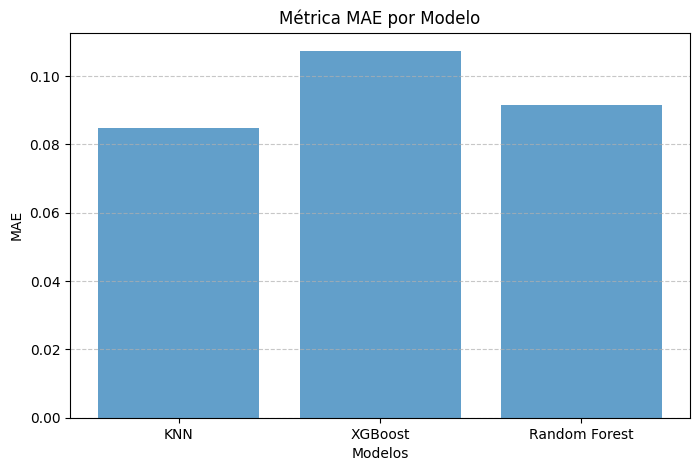

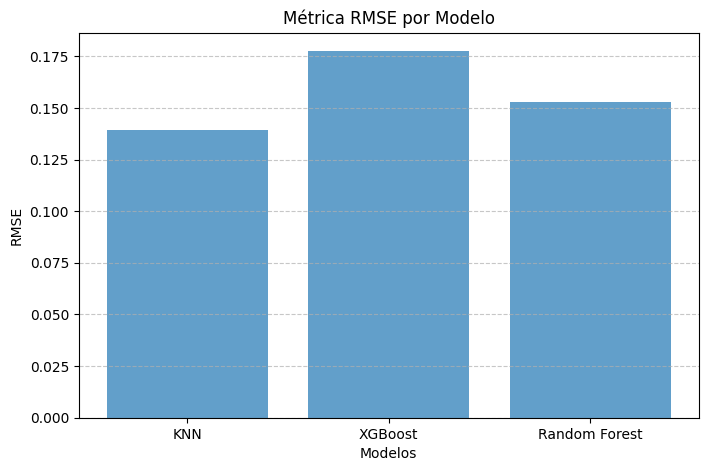

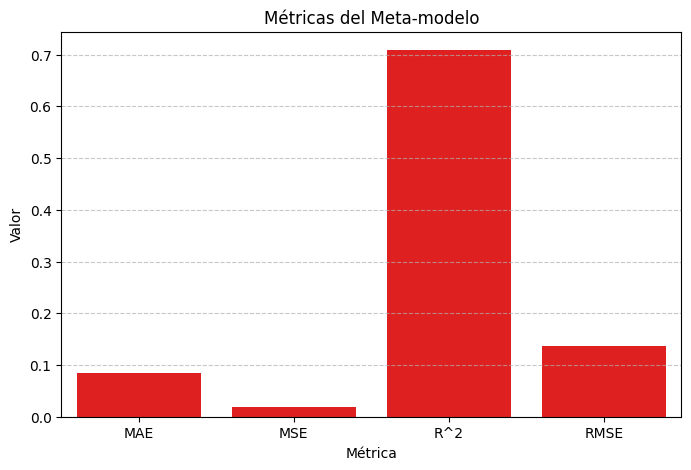


     Actual     Predicted
0       175    478.283217
1     22688  16189.862690
2       114    919.253488
3      1530   6333.106943
4     15954  15065.248894
..      ...           ...
108    1018   5887.585904
109     216   1019.281586
110     292    931.394290
111    7032   9492.832383
112     905    731.593870

[113 rows x 2 columns]



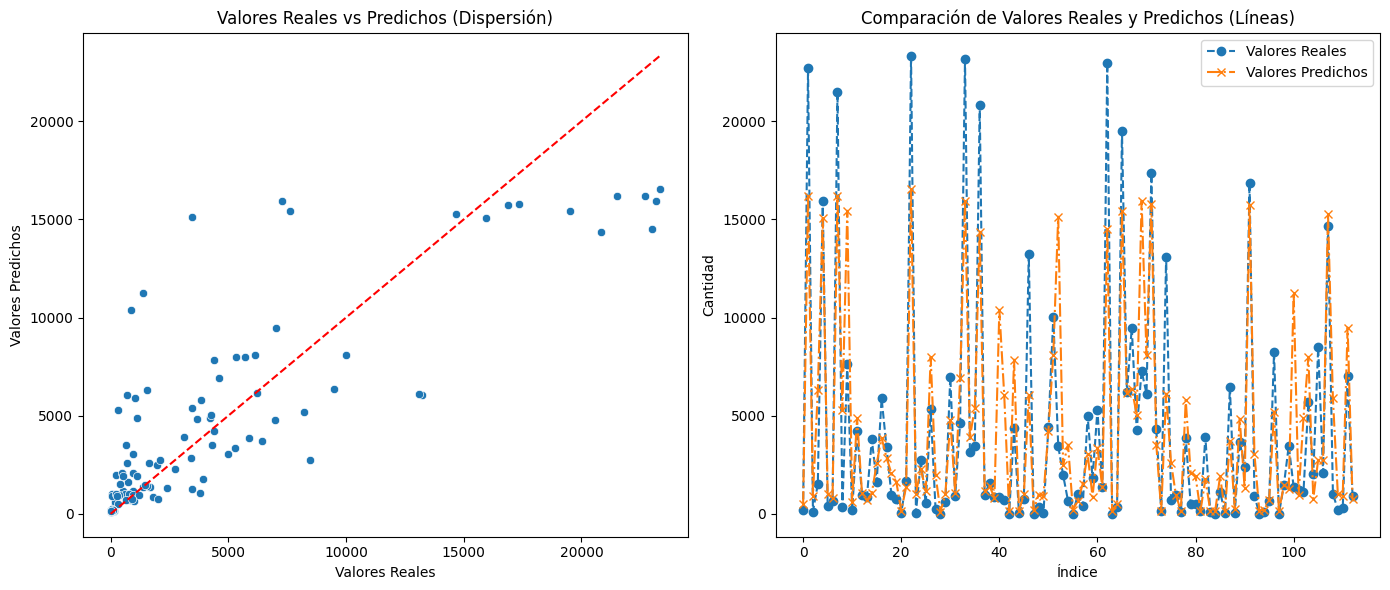

In [ ]:
# 7. EVALUACIÓN DEL MODELO
# Métricas de cada modelo base
base_models = {
    'KNN': stacking_model.named_estimators_['knn'],
    'XGBoost': stacking_model.named_estimators_['xgb'],
    'Random Forest': stacking_model.named_estimators_['rf']
}

# Calcular métricas para cada modelo base
model_metrics = {}
for model_name, model in base_models.items():
    y_pred_base = model.predict(X_test_scaled)
    mse_base = mean_squared_error(y_test, y_pred_base)
    mse_normalizado = mse_base / ((y_test.max() - y_test.min())**2)
    r2_base = r2_score(y_test, y_pred_base)
    mae_base = mean_absolute_error(y_test, y_pred_base)
    mae_normalizado = mae_base / (y_test.max() - y_test.min())
    rmse_base = np.sqrt(mse_base)
    rmse_normalizado = rmse_base / (y_test.max() - y_test.min())

    print(f"Métricas para {model_name}:")
    print(f"  Mean Squared Error (MSE): {mse_normalizado:.4f}")
    print(f"  R^2 Score: {r2_base:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae_normalizado:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse_normalizado:.4f}\n")

    model_metrics[model_name] = {
        'MSE': mse_normalizado,
        'R^2': r2_base,
        'MAE': mae_normalizado,
        'RMSE': rmse_normalizado
    }

# Métricas de evaluación de la salida del Stacking (Salida del Meta-modelo)
meta_mse = mean_squared_error(y_test, y_pred)
meta_r2 = r2_score(y_test, y_pred)
meta_mae = mean_absolute_error(y_test, y_pred)
meta_rmse = np.sqrt(meta_mse)

# Normalizar las métricas de la salida del Stacking
meta_mse_normalizado = meta_mse / ((y_test.max() - y_test.min())**2)
meta_rmse_normalizado = meta_rmse / (y_test.max() - y_test.min())
meta_mae_normalizado = meta_mae / (y_test.max() - y_test.min())
meta_metricas = {'MAE':meta_mae_normalizado, 'MSE':meta_mse_normalizado, 'R^2':meta_r2, 'RMSE':meta_rmse_normalizado}

# Mostrar las métricas del Stacking
print("Métricas del Stacking (Salida del Meta-modelo):")
print(f"  Mean Squared Error (MSE): {meta_mse_normalizado:.4f}")
print(f"  R^2 Score: {meta_r2:.4f}")
print(f"  Root Mean Squared Error (RMSE): {meta_rmse_normalizado:.4f}")
print(f"  Mean Absolute Error (MAE): {meta_mae_normalizado:.4f}\n")


# Gráficas de las métricas de los modelos base
metrics = ['MSE', 'R^2', 'MAE', 'RMSE'] # Fixed indentation here
for metric in metrics:
    values = [model_metrics[model][metric] for model in model_metrics]
    plt.figure(figsize=(8, 5))
    plt.bar(model_metrics.keys(), values, alpha=0.7)
    plt.title(f'Métrica {metric} por Modelo')
    plt.ylabel(metric)
    plt.xlabel('Modelos')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Dataframe para las metricas del Stacking (Salida del meta-modelo)
meta_metricas_df = pd.DataFrame({
    'Métrica': ['MAE', 'MSE', 'R^2', 'RMSE'],
    'Valor': [meta_mae_normalizado, meta_mse_normalizado, meta_r2, meta_rmse_normalizado]
})

meta_metricas_df = pd.DataFrame(list(meta_metricas.items()), columns=['Métrica', 'Valor'])

# Graficar las metricas del Stacking
plt.figure(figsize=(8, 5))
sns.barplot(x='Métrica', y='Valor', data=meta_metricas_df, errorbar=None, color='red')
plt.title('Métricas del Meta-modelo')
plt.ylabel('Valor')
plt.xlabel('Métrica')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Comparar los valores reales vs predichos
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).reset_index(drop=True)
print()
print(comparison)
print()

# Configurar las gráficas
plt.figure(figsize=(14, 6))

# Gráfico de dispersión
plt.subplot(1, 2, 1)
sns.scatterplot(x=comparison['Actual'], y=comparison['Predicted'])
plt.plot([comparison['Actual'].min(), comparison['Actual'].max()],
         [comparison['Actual'].min(), comparison['Actual'].max()],
         color='red', linestyle='--')
plt.title('Valores Reales vs Predichos (Dispersión)')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')

# Gráfico de líneas
plt.subplot(1, 2, 2)
plt.plot(comparison['Actual'].values, label='Valores Reales', marker='o', linestyle='--')
plt.plot(comparison['Predicted'].values, label='Valores Predichos', marker='x', linestyle='-.')
plt.title('Comparación de Valores Reales y Predichos (Líneas)')
plt.xlabel('Índice')
plt.ylabel('Cantidad')
plt.legend()

plt.tight_layout()
plt.show()


# **PREDICCIÓN POR CADA AÑO**

     Year  Actual  Predicted      fecha       categoria
12   2017    3286     3660.0 2017-01-01         Biblias
13   2017    4870     3803.0 2017-02-01         Biblias
14   2017     564     4137.0 2017-03-01         Biblias
15   2017    8486     3270.0 2017-04-01         Biblias
16   2017    6217     3650.0 2017-05-01         Biblias
..    ...     ...        ...        ...             ...
569  2023    3463    12621.0 2023-05-01  Titulos varios
570  2023   17353    15178.0 2023-06-01  Titulos varios
572  2023   21584    17199.0 2023-08-01  Titulos varios
573  2023   19324    16940.0 2023-09-01  Titulos varios
574  2023   15769    16579.0 2023-10-01  Titulos varios

[474 rows x 5 columns]
    Year              categoria   Actual  Predicted
0   2017                Biblias   5919.0     5470.0
1   2017         Denominacional   2538.0     2333.0
2   2017               Educases    113.0      186.0
3   2017               Himnario    564.0      658.0
4   2017  Libros de actividades    673.0    

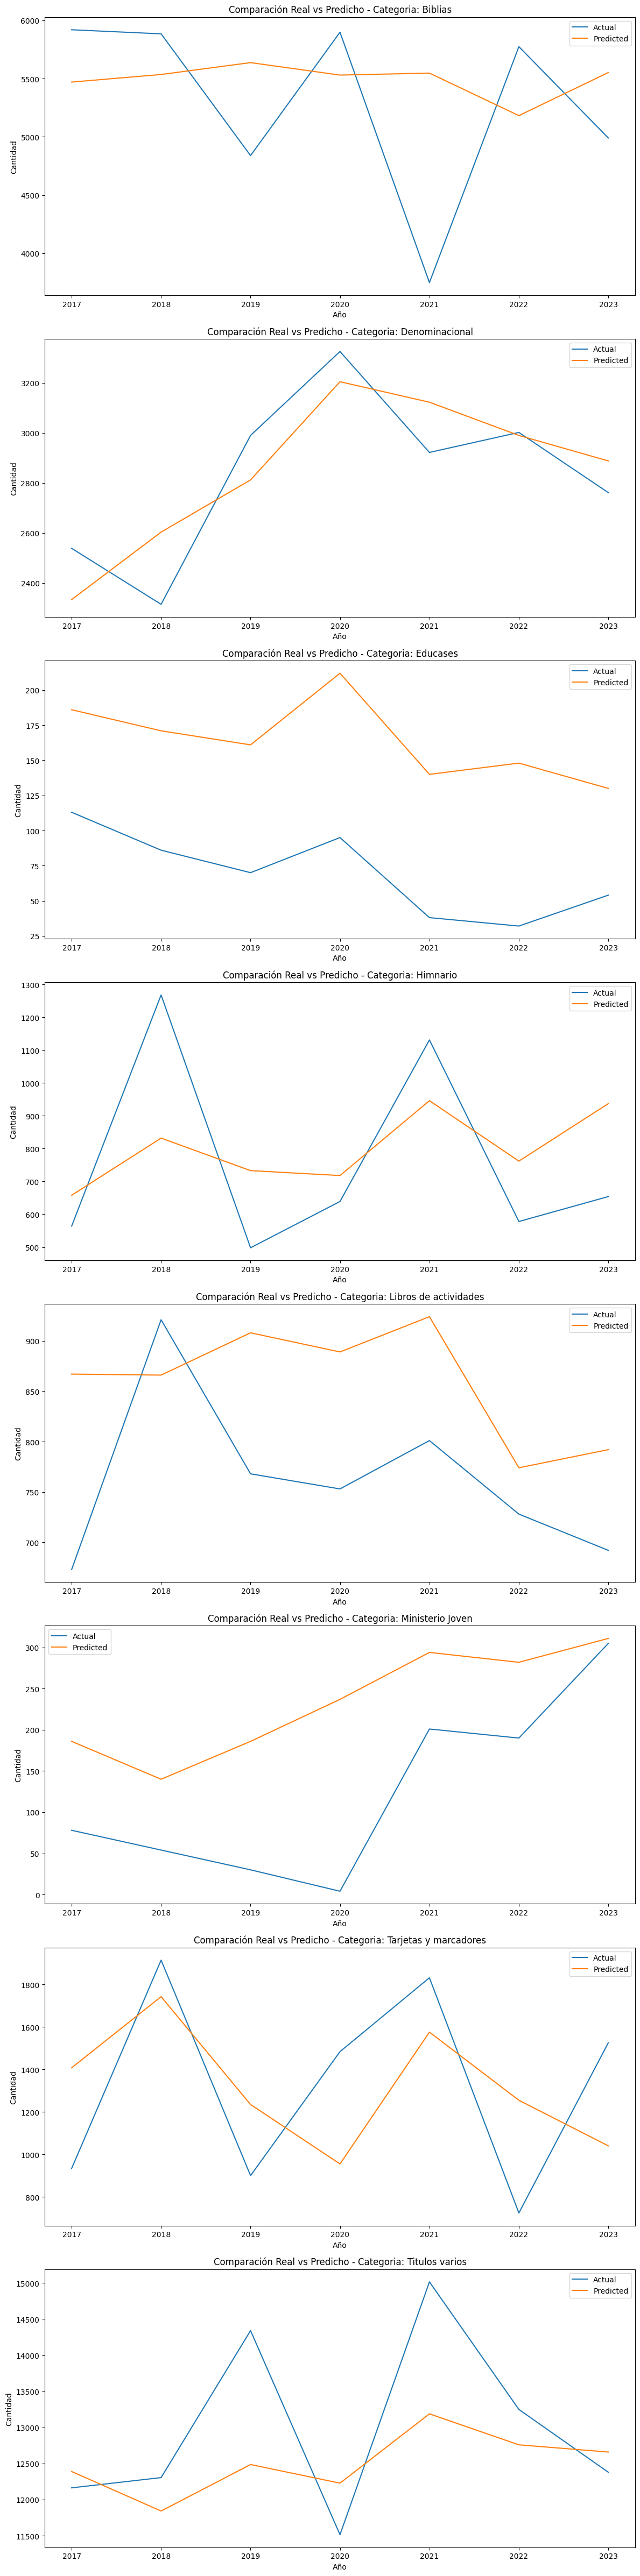

In [ ]:
df_test['cantegoria_Original'] = None

categorias_cols = [col for col in df_test.columns if col.startswith('categoria_')]

for idx, row in df_test.iterrows():
    for col in categorias_cols:
        if row[col] == 1:
            df_test.at[idx, 'categoria_Original'] = col.replace('categoria_', '')
            break

df_sum_categoria['categoria_Original'] = df_sum_categoria['categoria']

years = range(2017, 2024)
comparison_results = []

for year in years:
    df_year = df_encoded[df_encoded['Year'] == year]
    X_test = df_year.drop(columns=['cantidad', 'fecha'])
    y_test = df_year['cantidad']

    # Escalar datos de prueba
    X_test_scaled = scaler.transform(X_test)
    y_pred = stacking_model.predict(X_test_scaled)

    # Almacenar resultados
    comparison = pd.DataFrame({
        'Year': [year] * len(y_test),
        'Actual': y_test,
        'Predicted': y_pred
    })
    comparison = pd.merge(comparison, df_sum_categoria[df_sum_categoria['fecha'].dt.year == year][['fecha','categoria']], left_index=True, right_index=True, how='left')
    comparison_results.append(comparison)

# Unir todos los resultados
final_comparison = pd.concat(comparison_results).round(0)
print(final_comparison)

final_comparison.to_excel('predicciones_comparacion_inventario1.xlsx', index=False)

# Calcular cantidad promedio real y predicha por año y categoria
avg_comparison = final_comparison.groupby(['Year', 'categoria']).agg({
    'Actual': 'mean',
    'Predicted': 'mean'
}).reset_index().round(0)

print(avg_comparison)

# Graficar comparaciones por año y categoria
categorias = df_sum_categoria['categoria'].unique()
fig, axes = plt.subplots(nrows=len(categorias), figsize=(12, 6 * len(categorias)))

for i, categoria in enumerate(categorias):
    categoria_data = avg_comparison[avg_comparison['categoria'] == categoria]

    sns.lineplot(data=categoria_data, x='Year', y='Actual', label='Actual', ax=axes[i], errorbar=None)
    sns.lineplot(data=categoria_data, x='Year', y='Predicted', label='Predicted', ax=axes[i], errorbar=None)

    axes[i].set_title(f'Comparación Real vs Predicho - Categoria: {categoria}')
    axes[i].set_xlabel('Año')
    axes[i].set_ylabel('Cantidad')

plt.tight_layout()
plt.show()

# **PREDICCIÓN PARA EL AÑO 2024**

        fecha  cantidad_predicha
0  2024-01-01        5406.828502
1  2024-02-01        5513.226267
2  2024-03-01        5040.241295
3  2024-04-01        4904.066106
4  2024-05-01        6691.666002
..        ...                ...
91 2024-08-01       16416.403521
92 2024-09-01       16512.442970
93 2024-10-01       16505.197383
94 2024-11-01       16861.786192
95 2024-12-01       16861.786192

[96 rows x 2 columns]


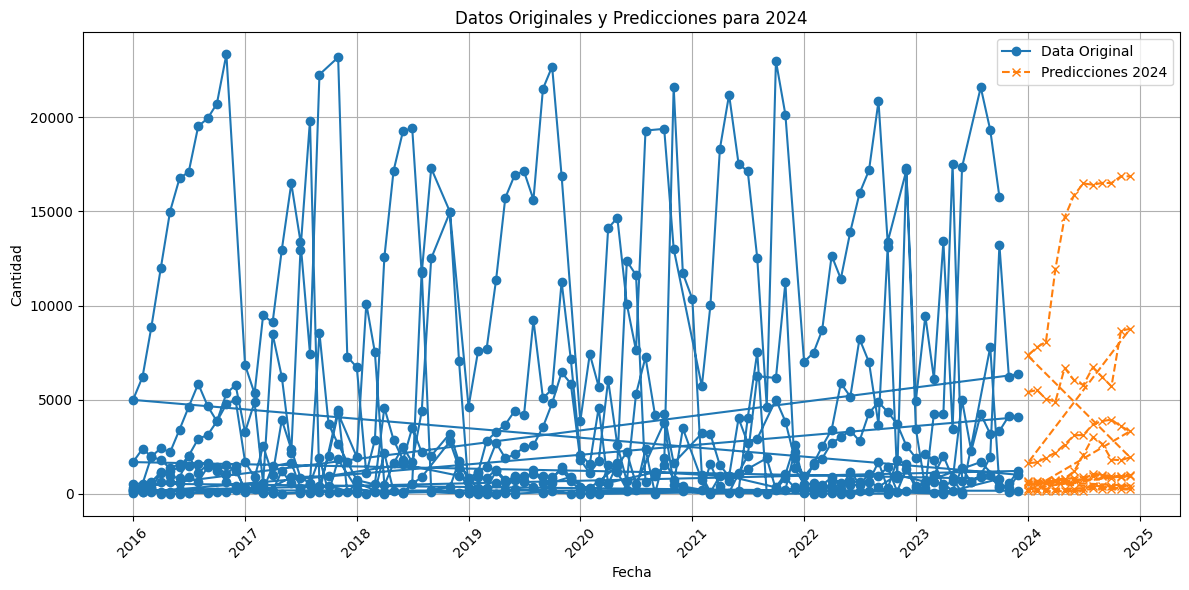

In [ ]:
# Crear datos futuros para el año 2024
unique_categorias = df_sum_categoria['categoria'].unique()
future_dates = pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS')

# Crear una lista para almacenar los datos futuros de cada 'categoria'
all_future_data = []

# Iterar a través de cada 'categoria' única para crear datos para 2024
for categoria in unique_categorias:
    future_data = pd.DataFrame({
        'fecha': pd.to_datetime(future_dates),
        'Year': future_dates.year,
        'Month': future_dates.month,
        'categoria': categoria
    })
    all_future_data.append(future_data)

# Concatenar todos los datos futuros en un solo DataFrame
future_data = pd.concat(all_future_data, ignore_index=True)

# Obtener las columnas originales utilizadas durante el entrenamiento
original_columns = X_train.columns

# Crear variables dummy para la columna 'categoria' y alinearlas con las columnas originales
future_data = pd.get_dummies(future_data, columns=['categoria'], prefix=['categoria'], prefix_sep='_')

# Asegurarse de que future_data tenga las mismas columnas que los datos originales
missing_cols = set(original_columns) - set(future_data.columns)
for col in missing_cols:
    future_data[col] = 0  # Agregar las columnas faltantes y rellenarlas con ceros

# Reordenar las columnas para que coincidan con las columnas originales, manteniendo 'fecha'
future_data_reordered = future_data[original_columns] # Seleccionar columnas para el modelo
future_data['cantidad_predicha'] = best_model.predict(scaler.transform(future_data_reordered)) # Predecir usando datos reordenados y transformados
future_results = future_data[['fecha', 'cantidad_predicha']] # Seleccionar columnas del DataFrame futuro que incluyan 'fecha'



# Mostrar las predicciones
print(future_results)

# Concatenar data original con predicciones para graficar
historical_data = df_sum_categoria[['fecha', 'cantidad']].rename(columns={'cantidad': 'cantidad_real'})
combined_data = pd.concat([
    historical_data,
    future_results.rename(columns={'cantidad_predicha': 'cantidad_real'})
])

# Graficar data original y predicciones
plt.figure(figsize=(12, 6))
plt.plot(historical_data['fecha'], historical_data['cantidad_real'], label='Data Original', marker='o', linestyle='-')
plt.plot(future_results['fecha'], future_results['cantidad_predicha'], label='Predicciones 2024', marker='x', linestyle='--')
plt.title('Datos Originales y Predicciones para 2024')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()